In [ ]:
import os
import numpy as np
import random
import glob
import pickle
import math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import time
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.applications import *
from tensorflow.keras import *


import seaborn as sns
import IPython.display as ipd
from IPython.core.display import display, clear_output


from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from collections import defaultdict

from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-cbc4ceb5-1b2a-1f35-7a10-cd2d09e0b5c8)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not os.path.exists('./IAM Dataset'):
    ret = os.system("cp '/content/drive/MyDrive/Dataset/IAM_line_images.zip' '/content/IAM_Handwritten_images.zip'")
    ret = os.system("cp '/content/drive/MyDrive/Dataset/IAM_line_labels.zip' '/content/IAM_Handwritten_labels.zip'")

    if ret == 0:  print("Data loaded")
    os.system("unzip -qq '/content/IAM_Handwritten_images.zip'")
    os.system("unzip -qq '/content/IAM_Handwritten_labels.zip'")
    print('unziped')
if os.path.exists('/content/IAM_line images'):
    !rm IAM_Handwritten_images.zip
    !rm IAM_Handwritten_labels.zip
    print('Zip removed')



Data loaded
unziped
Zip removed


In [ ]:
if not os.path.exists('./CVL_Dataset'):
    ret = os.system("cp '/content/drive/MyDrive/Dataset/CVL Dataset.zip' '/content/CVL_Dataset.zip' ")
    if  ret == 0: print('Data loaded')
    os.system("unzip -qq '/content/CVL_Dataset.zip'")

if os.path.exists('/content/CVL_Dataset.zip'):
  !rm CVL_Dataset.zip

Data loaded


In [ ]:
import cv2
import numpy as np
# For image drawing
from PIL import Image, ImageDraw, ImageFont, ImageEnhance

def change_contrast(img, level):
    # Input is a Image type
    # use Image.fromarray() on numpy
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)


def change_sharpness(img, level):
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(level)
    return img


def adjust(img, blevel, slevel, clevel, colevel):
    # brightness
    benhance = ImageEnhance.Brightness(img)
    img = benhance.enhance(blevel)
    # sharpness
    img = change_sharpness(img, slevel)
    # contrast
    img = change_contrast(img, clevel)
    # color
    cenhance = ImageEnhance.Color(img)
    img = cenhance.enhance(colevel)
    return img


def improveImage(img_dir):
    img = cv2.imread(img_dir, -1)
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0,
                                 beta=255, norm_type=cv2.NORM_MINMAX,
                                 dtype=cv2.CV_8UC1)

        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm


def convert_image(image_dir):
    img = improveImage(image_dir)
    img = adjust(Image.fromarray(img),
                  blevel=0.7, slevel=1, clevel=255,
                  colevel=1)
    return img

In [ ]:
from collections import defaultdict
d={}
labels_path = '/content/IAM_line labels/*'
check = {}
count = defaultdict(int)
for filename in sorted(glob.glob(labels_path)):
    tree = ET.parse(filename)
    root = tree.getroot()
    passage_id = root.attrib.get('id')
    check[root.attrib.get('writer-id')]=check.get(root.attrib.get('writer-id'),0)+1


for filename in sorted(glob.glob(labels_path)):
    tree = ET.parse(filename)
    root = tree.getroot()
    # if count[root.attrib.get('writer-id')]<5:
    if check[root.attrib.get('writer-id')]>=4 and count[root.attrib.get('writer-id')]<4:
            count[root.attrib.get('writer-id')] = count.get(root.attrib.get('writer-id'),0)+1
            for i in root.iter('line'):
                d[i.attrib.get('id')] = root.attrib.get('writer-id')

print(check)

image_files = []
ground_files = []
pseudo_files = []
images = sorted(glob.glob('/content/IAM_line images/**/*.png', recursive=True))
# images = sorted(glob.glob('//content/IAM_line images/c03/c03-000a/*.png', recursive=True))


for filename in sorted(tqdm(images)):
    s_filename = filename
    s_filename = s_filename.split('/')[-1]
    s_filename = s_filename.split('.')[0]

    try:
        im = Image.open(filename)
        if s_filename in d:
            image_files.append(filename)
            ground_files.append(d[s_filename])
            pseudo_files.append('-'.join(s_filename.split('-')[0:-1]))
    except:
      continue

image_files = np.asarray(image_files)
ground_files = np.asarray(ground_files)
ground_files = LabelEncoder().fit_transform(ground_files)
pseudo_files = np.asarray(pseudo_files)
pseudo_files = LabelEncoder().fit_transform(pseudo_files)
print(image_files.shape,ground_files.shape)
print(np.unique(image_files).shape,np.unique(ground_files).shape,np.unique(pseudo_files).shape)


{'000': 59, '001': 2, '002': 1, '003': 2, '004': 1, '005': 2, '006': 1, '007': 2, '008': 2, '009': 2, '010': 2, '011': 2, '012': 2, '013': 3, '014': 2, '015': 1, '016': 3, '017': 3, '018': 2, '019': 3, '020': 1, '021': 1, '022': 1, '023': 1, '024': 1, '025': 5, '026': 5, '027': 1, '028': 1, '029': 1, '030': 1, '031': 1, '032': 1, '033': 1, '034': 1, '035': 1, '036': 1, '037': 5, '038': 1, '039': 1, '040': 1, '041': 1, '042': 1, '043': 1, '044': 1, '045': 1, '046': 1, '047': 1, '048': 1, '049': 1, '050': 1, '051': 1, '052': 1, '053': 1, '054': 1, '055': 1, '056': 1, '058': 4, '059': 4, '060': 4, '061': 4, '062': 3, '063': 3, '064': 4, '065': 2, '066': 2, '067': 1, '068': 1, '069': 1, '070': 1, '071': 1, '072': 1, '073': 1, '074': 1, '075': 1, '076': 1, '077': 1, '078': 1, '079': 1, '080': 1, '081': 2, '082': 1, '083': 1, '084': 2, '085': 6, '086': 1, '087': 3, '088': 3, '089': 3, '090': 3, '091': 2, '092': 3, '093': 3, '094': 3, '095': 2, '096': 1, '097': 1, '098': 1, '099': 1, '100': 1

  0%|          | 0/13353 [00:00<?, ?it/s]

(4405,) (4405,)
(4405,) (127,) (508,)


In [ ]:
image_files = []
ground_files = []
images = sorted(glob.glob('/content/CVL Dataset/lines/**/*.tif', recursive=True))
count = defaultdict(int)
d = {}

for filename in sorted(tqdm(images)):
    s_filename = filename
    s_filename = s_filename.split('/')[-1]
    s_filename = s_filename.split('.')[0]
    gr = s_filename.split('-')[0]
    tx = int(s_filename.split('-')[1])*1
    # print(gr,tx)
    # break
    if not gr in d:
        d[gr] = tx
    if d[gr] == tx:
        try:
            im = Image.open(filename)

            image_files.append(filename)
            ground_files.append(gr)
        except:
            continue
print(d)
image_files = np.asarray(image_files)
ground_files = np.asarray(ground_files)
ground_files = LabelEncoder().fit_transform(ground_files)
print(image_files.shape,ground_files.shape)
print(np.unique(image_files).shape,np.unique(ground_files).shape)
print(np.unique(ground_files))

In [ ]:
image_files = []
ground_files = []
pseudo_files = []
images = sorted(glob.glob('/content/CVL Dataset/lines/**/*.tif', recursive=True))
count = defaultdict(int)
d = {}

for filename in sorted(tqdm(images)):
    s_filename = filename
    s_filename = s_filename.split('/')[-1]
    s_filename = s_filename.split('.')[0]
    gr = s_filename.split('-')[0]
    tx = int(s_filename.split('-')[1])
    try:
            im = Image.open(filename)

            image_files.append(filename)
            pseudo_files.append(f'{gr}_{tx}')
            ground_files.append(gr)
    except:
            continue
image_files = np.asarray(image_files)
ground_files = np.asarray(ground_files)
ground_files = LabelEncoder().fit_transform(ground_files)
pseudo_files = np.asarray(pseudo_files)
pseudo_files = LabelEncoder().fit_transform(pseudo_files)
print(image_files.shape,ground_files.shape,pseudo_files.shape)
print(np.unique(image_files).shape,np.unique(ground_files).shape,np.unique(pseudo_files).shape)

  0%|          | 0/13473 [00:00<?, ?it/s]

(13473,) (13473,) (13473,)
(13473,) (310,) (1598,)


In [ ]:
l = np.zeros((657,),dtype='int32')
x = []
gy = []
py = []
writer = 50

impurity = 0.0

for i in range(image_files.shape[0]):
  if ground_files[i]<writer:
      x.append(image_files[i])
      gy.append(ground_files[i])
      py.append(pseudo_files[i])
      im = convert_image(image_files[i])
      im.save(image_files[i],format='png')
      # im.save(image_files[i], compression='deflate')


x = np.asarray(x)
gy = np.asarray(gy)
gy = LabelEncoder().fit_transform(gy)
py = np.asarray(py)
py = LabelEncoder().fit_transform(py)
print(x.shape,gy.shape,py.shape)
print(np.unique(x).shape,np.unique(gy).shape,np.unique(py).shape)

(1731,) (1731,) (1731,)
(1731,) (50,) (200,)


In [ ]:
x_val = []
py_val = []
gy_val = []
input_shape = (112,224,3)
def image_resize(image, width = None, height = None):
        """Img is a PIL image"""
        dim = None
        (w, h) = image.size

        if width is None and height is None:
            return None
        if width is None:
            r = height / float(h)
            dim = (int(w * r), height)
        else:
            r = width / float(w)
            dim = (width, int(h * r))

        return image.resize(dim)

for i in range(x.shape[0]):
    im = Image.open(x[i])
    im = image_resize(im,height=input_shape[0])
    im = np.asarray(im,dtype=np.uint8)
    height,width = im.shape
    # height,width = im.shape
    if(width<input_shape[1]):continue
    rand = np.random.randint(low=0, high=max(im.shape[1]-input_shape[1]-1, 1),size=2)
    tmp = np.ones((112,224,3),dtype=np.uint8)
    for iter in rand:
        # tmp_img = im[:,iter:iter+input_shape[1],:]
        tmp_img = im[:,iter:iter+input_shape[1]]
        tmp[...,0] = tmp_img
        tmp[...,1] = tmp_img
        tmp[...,2] = tmp_img
        x_val.append(tmp)
        # x_val.append(tmp_img)
        py_val.append(py[i])
        gy_val.append(gy[i])

x_val = np.asarray(x_val,dtype=np.uint8)
py_val = np.asarray(py_val,dtype=np.int16)
gy_val = np.asarray(gy_val,dtype=np.int16)
# x = x[:,:,:,np.newaxis]
print(x_val.shape,py_val.shape,gy_val.shape)
print(np.unique(x_val,axis=0).shape,np.unique(py_val).shape,np.unique(gy_val).shape)

(3454, 112, 224, 3) (3454,) (3454,)
(1727, 112, 224, 3) (200,) (50,)


In [ ]:
import math
import imageio
img = []
pse_label=[]
grd_label = []
input_shape = (112,224,1)

def image_resize(image, width = None, height = None):
        """Img is a PIL image"""
        dim = None
        (w, h) = image.size

        if width is None and height is None:
            return None
        if width is None:
            r = height / float(h)
            dim = (int(w * r), height)
        else:
            r = width / float(w)
            dim = (width, int(h * r))

        return image.resize(dim)
if not os.path.exists('/content/Train'):
    os.makedirs('/content/Train')
for i in range(x.shape[0]):
    im = Image.open(x[i])
    im = image_resize(im,height=input_shape[0])
    im = np.asarray(im,dtype=np.uint8)
    height,width = im.shape
    # height,width = im.shape

    end_pos = 0
    count = 0
    while end_pos < width-224:
        tmp_img = im[:,end_pos:end_pos+224]
        # tmp_img = im[:,end_pos:end_pos+224,:]
        end_pos = end_pos+224
        tmp = np.ones((112,224,3),dtype=np.uint8)
        # tmp = tmp_img
        tmp[...,0]=tmp_img
        tmp[...,1]=tmp_img
        tmp[...,2]=tmp_img
        tmp = Image.fromarray(tmp)
        tmp.save(f'/content/Train/{gy[i]}_{py[i]}_{i}_{count}.png')
        img.append(f'/content/Train/{gy[i]}_{py[i]}_{i}_{count}.png')
        # img.append(tmp)
        pse_label.append(py[i])
        grd_label.append(gy[i])
        count+=1

# img = img[:,:,:,np.newaxis]
# X = np.asarray(img,dtype=np.uint8)
py = np.asarray(pse_label,dtype=np.int16)
gy = np.asarray(grd_label,dtype=np.int16)
# x = x[:,:,:,np.newaxis]
# print(X.shape,py.shape,gy.shape)
# print(np.unique(X,axis=0).shape,np.unique(py).shape,np.unique(gy).shape)
X = img
print(len(X),py.shape,gy.shape)
print(np.unique(py).shape,np.unique(gy).shape)

11159 (11159,) (11159,)
(200,) (50,)


In [ ]:
def makeImpure(data_y, ratio=0, seed=42):
    if ratio == 0:
        return data_y

    tot_writer = len(np.unique(data_y))
    tot_impurs = int(data_y.shape[0]*ratio)
    rand = random.Random(seed)

    idxs = rand.sample(range(data_y.shape[0]), tot_impurs)
    shuffle_data = data_y[idxs]
    rand.shuffle(shuffle_data)

    ret_data = np.copy(data_y)
    ret_data[idxs] = shuffle_data

    return ret_data

py = makeImpure(py,ratio=impurity)

print(len(X),py.shape,gy.shape)
print(np.unique(py).shape,np.unique(gy).shape)

16516 (16516,) (16516,)
(304,) (50,)


In [ ]:
import shutil
if os.path.exists('/content/IAM_line images'):
    shutil.rmtree('/content/IAM_line images')
    shutil.rmtree('/content/IAM_line labels')
if os.path.exists('/content/CVL Dataset'):
    shutil.rmtree('/content/CVL Dataset')

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"
import albumentations as albu

     |████████████████████████████████| 102 kB 7.1 MB/s 
     |████████████████████████████████| 47.8 MB 2.1 MB/s 
albumentations==1.1.0 is successfully installed


In [ ]:
class AEGenerator(tf.keras.utils.Sequence):
    """ Recieves X and y
        Performes pairwise matching with a batch size
        both pairs are generated from the input X and y

        imgs         : Input image directory
        y            : Pseudo label, Numpy Array, Output shape=(bs, ) or (bs, 1)
        gt           : Ground truth of the actual class, Numpy Array, Output shape=(bs, ) or (bs, 1).
        dist      : Distance parameter for AE
        noise     : Ratio of augmentation compression='deflate'
        scale     : The maximum limit of noise that would be mixed with X
        show_logs : Show random selection errors

                    Use only when show_logs is True

        dg = AEGenerator(iX=X, iy=cy, dist=dist, noise=noise,
                         batch_size=batch_size, scale=aug_scale,
                         show_logs=False, gt=y,
                         output_channel=1 if model == 'MobileNet' else 3)

    """

    def __init__(self, imgs, pseudo_label, dist, ground_label, input_shape,
                 batch_size=64, show_logs=True, prob=1.0, validation=False):

        self.batch_size  = batch_size
        self.x = imgs
        self.py = pseudo_label
        self.gy = ground_label

        # Probability of augmentation
        self.prob = prob

        if self.py.shape[-1] == 1:
            self.py = np.squeeze(self.py)
        if self.gy.shape[-1] == 1:
            self.gy = np.squeeze(self.gy)

        assert len(input_shape) == 3, 'Input shape must be 3 dimentional'
        self.input_shape = input_shape

        self.total = len(self.x)
        self.dist = dist

        # Generates label : indexes_where_label_found
        ulabels = np.unique(self.py)
        self.class_index = dict([(label, list(np.where(self.py == label)[0])) \
                                 for label in ulabels])

        self.indexes     = np.arange(self.total)
        self.total_batch = self.total // self.batch_size
        self.classes = len(ulabels)

        self.rand = random.Random(12)
        random.seed(12)

        self.log = {}
        self.show_logs = show_logs
        self.on_epoch_end()
        self.aug_func = AEGenerator.strong_aug(self.input_shape, p=self.prob)


    # Strong augmentation features
    @staticmethod
    def strong_aug(img_shape, p=0.6):
        # horizontal
        hh = int(img_shape[0]*0.8)
        hw = int(img_shape[1]*0.08)
        # vertical
        vh = int(img_shape[0]*0.04)
        vw = int(img_shape[1]*0.8)
        return albu.Compose([
            # albu.RandomSizedCrop((img_shape[0]-int(img_shape[0]*0.8),
            #                          img_shape[0]+int(img_shape[0]*0.8)),
            #                          img_shape[0], img_shape[1],
            #                          (img_shape[1]-int(img_shape[1](0.4)),
            #                          img_shape[1]),
            #                       p=0.5),
            # albu.Flip(0.5),
            # albu.Downscale(),
            # albu.ShiftScaleRotate(shift_limit=0, scale_limit=[-0.6, 0.6],
            #   rotate_limit=45, p=0.5),

            albu.OneOf([
                        albu.Flip(p=0.5),
                        albu.VerticalFlip(p=0.5),
            ],p = 0.5),
            albu.OneOf([
                        albu.Downscale(p=0.5),
                        albu.GaussianBlur(p=0.5),
                        albu.MotionBlur(p=0.5)
            ],p = 0.5),
            # albu.OneOf([
            #             albu.ShiftScaleRotate(shift_limit=0,
            #                                   scale_limit=[-0.5, 0],
            #                                   rotate_limit=[-15,15], p=0.5),
            #             albu.OpticalDistortion(distort_limit=[0,0.5],p=0.5)
            # ],p = 0.5),
            albu.OneOf([
                        albu.MultiplicativeNoise(p=0.5),
                        albu.RandomBrightnessContrast(p=0.5),
                        albu.GaussNoise(p=0.5)
            ],p = 0.5),
            albu.OneOf([
                        albu.Cutout(num_holes=8, max_h_size=16, max_w_size=16,
                         fill_value=255, p=0.5),
                        albu.CoarseDropout(max_holes=8, max_height=16, max_width=16,fill_value=0, p=0.5)
            ],p = 0.5)
        ], p=p)




    def __len__(self):
        """ Denotes the number of batches per epoch """
        return self.total_batch


    def _print_logs(self):
        for a, b in self.log.items():
            print(a, ':', b)


    def on_epoch_end(self):
        """ Updates indexes after each epoch """
        np.random.shuffle(self.indexes)
        if self.show_logs:
            self._print_logs()
            self.log['canNotLink_error'] = 0
            self.log['time'] = 0


    def _make_choice(self, p=None):
        w = [0.5, 0.5]
        if p is not None:
            w = [p, 1-p]
        return self.rand.choices([True, False], weights=w)[0]


    def _augment(self, imgs):
        """ Inputs some image indices,
            Returns the augmented images
            Input_dim : [2*batch_size, ]
        """
        aug_imgs = np.zeros((len(imgs), ) + self.input_shape, dtype=np.uint8)

        #print('Imgs:', imgs.shape)
        for i in range(len(imgs)):
            aug_imgs[i] = self.aug_func(image=imgs[i])['image']
            # print('Augmented')
            # plt.imshow(aug_imgs[i], cmap='gray')
            # plt.show()

        return aug_imgs


    def __getitem__(self, batch_index):
        """ Generate one batch of data """
        idx, y = self._genIndexes(batch_index)
        #img_dirs = self.x[idx]

        imgs = np.ones((2*self.batch_size, ) + self.input_shape, dtype=np.uint8)
        for i in range(2*self.batch_size):
            tmp_img = Image.open(self.x[idx[i]])
            imgs[i] = tmp_img

        if self.prob > 0:
            aug_idx = self.rand.sample(range(2*self.batch_size), k=self.batch_size)
            imgs[aug_idx] = self._augment(imgs[aug_idx])


        return [imgs[:self.batch_size], imgs[self.batch_size:]], y



    def _genIndexes(self, index):
        idx = np.zeros((2, self.batch_size), dtype=np.int16)
        idx[0] = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        constraint = np.zeros(self.batch_size, dtype=np.int16)

        for i in range(self.batch_size):
            plabel = self.py[idx[0][i]]
            take = idx[0][i]
            # Generating must-links
            if self._make_choice():
                take = self.rand.choice(self.class_index[plabel])
                # Generating can-not links
            else:
                # Taking random pair
                while self.py[take] == plabel:
                    take = self.rand.choice(self.indexes)
                constraint[i] = self.dist

                if self.show_logs and self.gy[idx[0][i]] == self.gy[take]:
                    self.log['canNotLink_error'] += 1

            idx[1][i] = take

        return idx.reshape((2*self.batch_size)), constraint

In [ ]:
dg = AEGenerator(imgs=X, pseudo_label=py,
                    dist=100, ground_label=gy, input_shape=(112, 224, 3),
                    batch_size=64, show_logs=True, validation=False,
                    # Setting augmentation probability
                    prob=0.5)



xx,yy = dg[0]

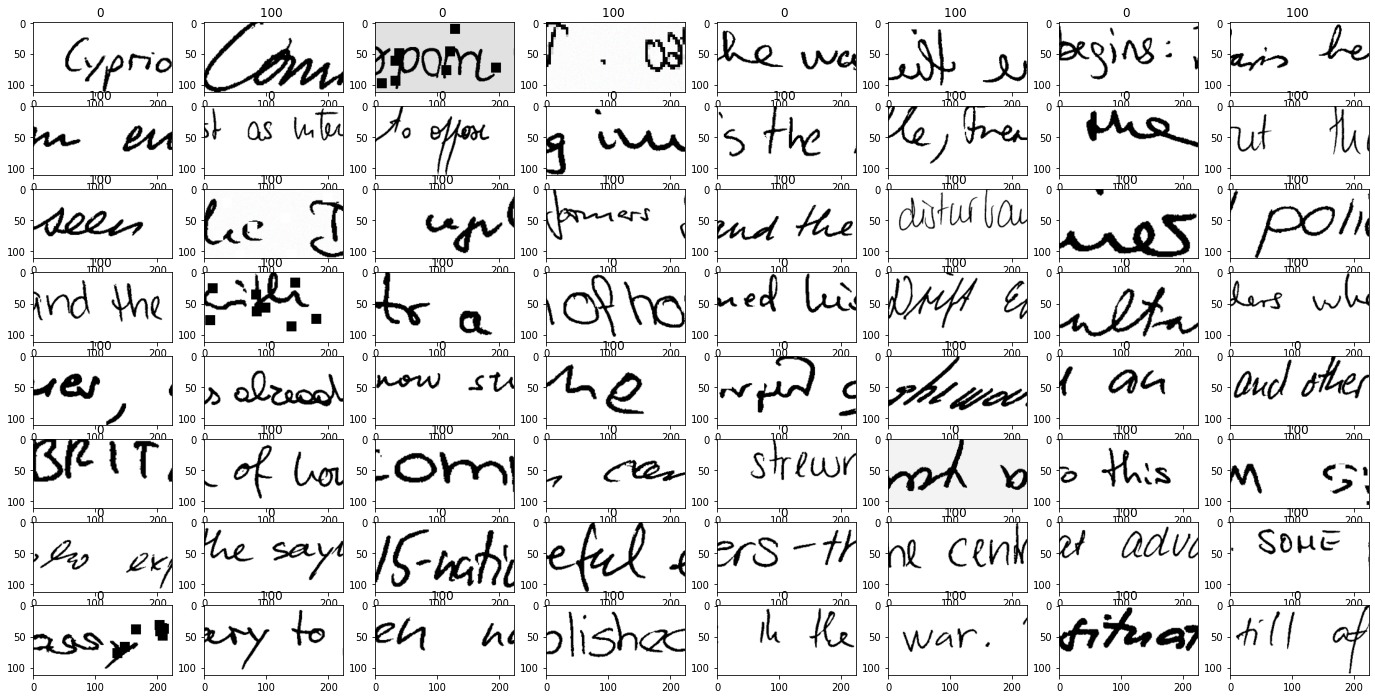

In [ ]:

_, ax = plt.subplots(8, 8, figsize=(24, 12))
for i in range(64):
    ax[i//8, i%8].imshow(xx[0][i, :, :,:])
    ax[i//8 ,i%8].set_title(f"{yy[i]} ", )

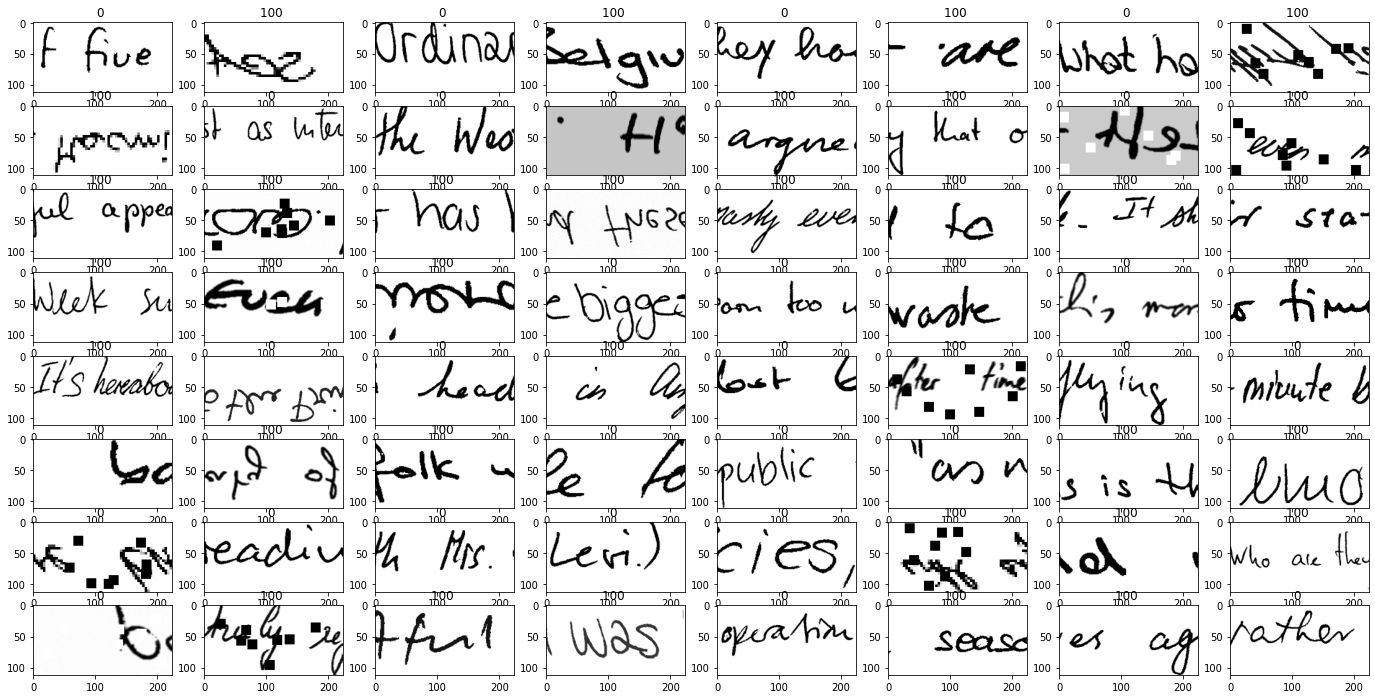

In [ ]:
_, ax = plt.subplots(8, 8, figsize=(24, 12))
for i in range(64):
    ax[i//8, i%8].imshow(xx[1][i, :, :,:], cmap="gray")
    ax[i//8 ,i%8].set_title(f"{yy[i]} " )

In [ ]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [64, 128, 256] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = tf.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x
def middle_flow(x, num_blocks=3) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        # x = Activation('relu')(x)
        # x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = tf.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(512, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(512, 1, strides=2, padding='same')(previous_block_activation)
    x = tf.keras.layers.Add()([x, residual])

    x = SeparableConv2D(512, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    return x
def create_xception(input_shape,dims):
    inputs = Input(shape=input_shape)
    outputs = exit_flow(middle_flow(entry_flow(inputs)))
    outputs = Dense(dims)(outputs)
    xception = tf.keras.Model(inputs, outputs)
    return xception


In [ ]:
class Distance(tf.keras.layers.Layer):
    def __init__(self, alpha=100, *args, **kwargs):
        self.alpha = alpha
        super().__init__(*args, **kwargs)
        self.activation = tf.keras.layers.ReLU(max_value=self.alpha)

    def call(self, inputs):
        dist = tf.expand_dims(tf.math.sqrt(tf.math.reduce_sum(tf.math.square(inputs[0]-inputs[1]),
                                                              axis=1)),
                              axis=-1)
        return self.activation(dist)

    def get_config(self):
        return {"alpha": self.alpha}


def buildAE(input_shape, dims, alpha=1, dis=100, topmodel = 'MobileNet',
            scale=None, setup=0, dropout=0.001, decay=False):

    inp1 = Input(input_shape, name='input1')
    input1 = tf.keras.layers.Lambda(lambda x: (x/255.0))(inp1)
    inp2 = Input(input_shape, name='input2')
    input2 = tf.keras.layers.Lambda(lambda x: (x/255.0))(inp2)


    # topmodel = eval(f"{topmodel}(input_shape={input_shape}," +
    #                     "include_top=False, weights='imagenet')")

    # m = Sequential([topmodel,
    #                 Flatten(),
    #                 Dense(dims)], name='AutoEmbedder')
    m = create_xception(input_shape,dims)

    out1 = m(input1)
    out2 = m(input2)


    # Calculating distance
    out = Distance()([out1, out2])

    # Initializing model
    model = Model([inp1, inp2], out, name="AE_train")

    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0005),
                   loss='mse')
    AE = Model(inp1, out1, name="AutoEmbedder")

    return model, AE


previous callback


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def accuracy(true_row_labels, predicted_row_labels):
    """Get the best accuracy.
    Parameters
    ----------
    true_row_labels: array-like
        The true row labels, given as external information
    predicted_row_labels: array-like
        The row labels predicted by the model
    Returns
    -------
    float
        Best value of accuracy
    """
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    rows, columns = linear_sum_assignment(_make_cost_m(cm))
    total = 0
    for row, column in zip(rows, columns):
        value = cm[row][column]
        total += value

    return (total * 1. / np.sum(cm))
class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=1, validation_data=None,savepath=None,save_model=True,AE=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data is not None:
            self.x_val, self.py_val ,self.gy_val= validation_data
            self.py_classes = len(np.unique(self.py_val))
            self.gy_classes = len(np.unique(self.gy_val))
        self.start_time = time.time()
        self.start_epoch = 0
        self.savepath=savepath
        self.save_model = save_model
        self.AE = AE

        self.minLoss = 99999

        self.savelog = {'Epoch': [], 'loss' : [],
                        'K-means_PY_ACC':[], 'K-means_PY_NMI':[], 'K-means_PY_ARI':[], 'K-means_GY_ACC':[], 'K-means_GY_NMI':[], 'K-means_GY_ARI':[],}
                        #'EM_PY_ACC':[], 'EM_PY_NMI':[], 'EM_PY_ARI':[], 'EM_GY_ACC':[], 'EM_GY_NMI':[], 'EM_GY_ARI':[],}
                        #'Birch_PY_ACC':[], 'Birch_PY_NMI':[], 'Birch_PY_ARI':[], 'Birch_GY_ACC':[], 'Birch_GY_NMI':[], 'Birch_GY_ARI':[]}



        if self.savepath != None:
            self.logpath = os.path.join(self.savepath, 'log.pickle')
            self.opti_path = os.path.join(self.savepath, 'optimizer.pkl')
            self.modelpath = os.path.join(self.savepath, 'model_weights.h5')
        # Creating save paths
        if self.savepath != None and os.path.exists(self.savepath) == False:
            os.makedirs(self.savepath)
        # Loading previous data if found
        if self.savepath != None and os.path.exists(self.logpath):
            with open(self.logpath, 'rb') as f:
                self.savelog = pickle.load(f)
            print('Previous data loaded, starting epoch:', self.savelog['Epoch'][-1])
            self.start_epoch = self.savelog['Epoch'][-1]
            self.minLoss = min(self.savelog['loss'])




    def on_epoch_end(self, epoch, logs={}):

        self.start_epoch +=1
        if self.start_epoch % self.n != 0 and self.start_epoch != 1: return

        rindex = random.sample(range(0, self.py_val.shape[0]), self.py_classes*5)
        self.start_time = time.time()

        t_k_means_acc, t_k_means_nmi, t_k_means_ari = self._KmeansAcc(self.py_classes,self.py_val,rindex)
        v_k_means_acc, v_k_means_nmi, v_k_means_ari = self._KmeansAcc(self.gy_classes,self.gy_val,rindex)

        # t_em_acc, t_em_nmi, t_em_ari = self._EMG(self.py_classes,self.py_val,rindex)
        # v_em_acc, v_em_nmi, v_em_ari = self._EMG(self.gy_classes,self.gy_val,rindex)

        # t_birch_acc, t_birch_nmi, t_birch_ari = self._Birch(self.py_classes,self.py_val)
        # v_birch_acc, v_birch_nmi, v_birch_ari = self._Birch(self.gy_classes,self.gy_val)

        ep_time = time.time() - self.start_time
        print(f"\rEpoch {self.start_epoch}: K-means_PY_NMI {t_k_means_nmi:.5f} K-means_PY_ACC {t_k_means_acc:.5f} K-means_PY_ARI {t_k_means_ari:.5f} Time:{ep_time:.1f}",
              end='\n')
        print(f"\rEpoch {self.start_epoch}: K-means_GY_NMI {v_k_means_nmi:.5f} K-means_GY_ACC {v_k_means_acc:.5f} K-means_GY_ARI {v_k_means_ari:.5f} Time:{ep_time:.1f}",
              end='\n')
        # print(f"\rEpoch {self.start_epoch}: EM_PY_NMI {t_em_nmi:.5f} EM_PY_ACC {t_em_acc:.5f} EM_PY_ARI {t_em_ari:.5f} Time:{ep_time:.1f}",
        #       end='\n')
        # print(f"\rEpoch {self.start_epoch}: EM_GY_NMI {v_em_nmi:.5f} EM_GY_ACC {v_em_acc:.5f} EM_GY_ARI {v_em_ari:.5f} Time:{ep_time:.1f}",
        #       end='\n')
        # print(f"\rEpoch {self.start_epoch}: Birch_PY_NMI {t_birch_nmi:.5f} Birch_PY_ACC {t_birch_acc:.5f} Birch_PY_ARI {t_birch_ari:.5f} Time:{ep_time:.1f}",
        #       end='\n')
        # print(f"\rEpoch {self.start_epoch}: Birch_GY_NMI {v_birch_nmi:.5f} Birch_GY_ACC {v_birch_acc:.5f} Birch_GY_ARI {v_birch_ari:.5f} Time:{ep_time:.1f}",
        #       end='\n')
        self._saveLog(self.start_epoch, logs['loss'],
                      t_k_means_acc, t_k_means_nmi, t_k_means_ari, v_k_means_acc, v_k_means_nmi, v_k_means_ari,)
                      # t_em_acc, t_em_nmi, t_em_ari, v_em_acc, v_em_nmi, v_em_ari,)
                      # t_birch_acc, t_birch_nmi, t_birch_ari, v_birch_acc, v_birch_nmi, v_birch_ari)

        if self.savepath != None:# and logs['loss'] < self.minLoss:
            print(f'Saving model, prev :{self.minLoss:.2f}')
            self.minLoss = min(self.savelog['loss'])
            with open(self.logpath, 'wb') as f:
                pickle.dump(self.savelog, f)
            if self.save_model:
                self.model.save_weights(filepath=self.modelpath, overwrite=True, )

                symbolic_weights = getattr(self.model.optimizer, 'weights')
                weight_values = K.batch_get_value(symbolic_weights)
                with open(self.opti_path, 'wb') as f:
                    pickle.dump(weight_values, f)



    def _saveLog(self, epoch, loss,t_k_means_acc, t_k_means_nmi, t_k_means_ari, v_k_means_acc, v_k_means_nmi, v_k_means_ari):#, t_em_acc, t_em_nmi, t_em_ari, v_em_acc, v_em_nmi, v_em_ari):#, t_birch_acc, t_birch_nmi, t_birch_ari, v_birch_acc, v_birch_nmi, v_birch_ari):
        self.savelog['Epoch'].append(epoch)
        self.savelog['loss'].append(loss)
        self.savelog['K-means_PY_ACC'].append(t_k_means_acc)
        self.savelog['K-means_PY_NMI'].append(t_k_means_nmi)
        self.savelog['K-means_PY_ARI'].append(t_k_means_ari)
        self.savelog['K-means_GY_ACC'].append(v_k_means_acc)
        self.savelog['K-means_GY_NMI'].append(v_k_means_nmi)
        self.savelog['K-means_GY_ARI'].append(v_k_means_ari)

        # self.savelog['EM_PY_ACC'].append(t_em_acc)
        # self.savelog['EM_PY_NMI'].append(t_em_nmi)
        # self.savelog['EM_PY_ARI'].append(t_em_ari)
        # self.savelog['EM_GY_ACC'].append(v_em_acc)
        # self.savelog['EM_GY_NMI'].append(v_em_nmi)
        # self.savelog['EM_GY_ARI'].append(v_em_ari)

        # self.savelog['Birch_PY_ACC'].append(t_birch_acc)
        # self.savelog['Birch_PY_NMI'].append(t_birch_nmi)
        # self.savelog['Birch_PY_ARI'].append(t_birch_ari)
        # self.savelog['Birch_GY_ACC'].append(v_birch_acc)
        # self.savelog['Birch_GY_NMI'].append(v_birch_nmi)
        # self.savelog['Birch_GY_ARI'].append(v_birch_ari)


    def _EMG(self,classes,y_val,rindex):

        EM = GaussianMixture(n_components=classes)
        # AE = self.model.layers[2]
        # rindex = random.sample(range(0, y_val.shape[0]), classes*5)
        outs = self.AE.predict(self.x_val[rindex])
        y_pred = EM.fit_predict(outs)
        acc = accuracy(y_val[rindex],y_pred)
        nmi = normalized_mutual_info_score(y_val[rindex], y_pred)
        ari = adjusted_rand_score(y_val[rindex], y_pred)

        return (acc, nmi, ari)

    def _Birch(self,classes,y_val):
        birch = Birch(n_clusters=classes)
        AE = self.model.layers[2]
        outs = AE.predict(self.x_val)
        y_pred = birch.fit_predict(outs)
        acc = accuracy(y_val,y_pred)
        nmi = normalized_mutual_info_score(y_val, y_pred)
        ari = adjusted_rand_score(y_val, y_pred)

        return (acc, nmi, ari)


    def _KmeansAcc(self,classes,y_val,rindex):
        kmeans = KMeans(n_clusters=classes, n_init=10)
        #AE = self.model.layers[2]
        # rindex = random.sample(range(0, y_val.shape[0]), classes*5)
        outs = self.AE.predict(self.x_val[rindex])
        y_pred = kmeans.fit_predict(outs)
        acc = accuracy(y_val[rindex], y_pred)
        nmi = normalized_mutual_info_score(y_val[rindex], y_pred)
        ari = adjusted_rand_score(y_val[rindex], y_pred)
        #top_5 = top_k_accuracy_score(self.y_val[rindex],y_pred,k=5)

        return (acc, nmi, ari)

In [ ]:
model='Shallow_xception'
# dataset = 'IAM'
dataset = 'CVL'
dist=100
input_shape = (112,224,3)
dims=16
batch_size=64
epochs=200

line = 2
n=2
# impurity = 0.1

base_dir = '/content/drive/MyDrive/UWriter_final/Pairwise_aug/full_logs'
load_pretrain=False
pretrain_path=None
print(x_val.shape,np.unique(py_val).shape)

(3454, 112, 224, 3) (200,)


In [ ]:
 # def trainModel(model, X, cy, y, input_shape = (112,224,3), dist=100, dims=3, setup=2,
#                batch_size=64, epochs=3000, writer="25",line=5,
#                load_pretrain=False, base_dir=base_dir,
#                pretrain_path=None):
'''
    This would check if previously ran model exists, and load it in model and
    AE. This function would return MyLogger callback object and the starting
    epoch for the model. Necessary savepath parameters would be declared in this
    function as parameter.

    Possible Naming Scheme: Model_dist_dims_setup_scale_frame_[T,L,B]_MIN_SPKRs_CLIM
    T : TIMIT
    L : LibriSpeech
    B : Bengali ASR
    dist  : Distance between clusters (known as AutoEmbedder alpha parameter)
    dims  : The output dimention of AutoEmbedder
    frame : Frame size (input frame size)
    scale : The scaling feature of speech (spectrogram, mfcc)
    SPKRS : Number of speakers
    CLIM  : Maximum Inter-cluster-linkage
    MIN   : Minutes of speech per-speaker
    '''

strat = tf.distribute.MirroredStrategy()
global AE
tf.keras.backend.clear_session()
nmodel = f"{model}" if model == 'MobileNet' else f"{model}"
pname = f"{nmodel}_D{dims}_W{writer}_P{impurity}_{dataset}"

loaded = False
save_dir = os.path.join(base_dir, pname)
opti_dir = os.path.join(save_dir,'optimizer.pkl')

dg = AEGenerator(imgs=X, pseudo_label=py,
                    dist=100, ground_label=gy, input_shape=(112, 224, 3),
                    batch_size=batch_size, show_logs=True, validation=False,
                    # Setting augmentation probability
                    prob=0)


if os.path.exists(os.path.join(save_dir, 'model_weights.h5')):
    try:
        print('Previous weights found, building model')
        with strat.scope():
            model, AE = buildAE(input_shape, dims=dims,
                                dis=100, topmodel=model)
            print('Loading weights')
            model.load_weights(os.path.join(save_dir, 'model_weights.h5'))
        loaded = True
    except Exception as e:
        print(str(e))
        pass

    print('loading optimizer')
    grad_vars = model.trainable_weights
    zero_grads = [tf.zeros_like(w) for w in grad_vars]
    model.optimizer.apply_gradients(zip(zero_grads, grad_vars))
    with open(opti_dir, 'rb') as f:
      weight_values = pickle.load(f)
    model.optimizer.set_weights(weight_values)


if not loaded:
    print('Initializing new model')
    with strat.scope():
        model, AE = buildAE(input_shape, dims=dims,
                            dis=100, topmodel=model)
    loaded = True


print(len(X), py.shape, gy.shape)


# log = MyLogger(n,validation_data=(X,py,gy),savepath=save_dir,
#                save_model=True,AE=AE)
log = MyLogger(n,validation_data=(x_val,py_val,gy_val),savepath=save_dir,
               save_model=True,AE=AE)

model.summary()
AE.summary()
    #time.sleep(1)
    #AE.summary()

print('Starting model training')
model.fit(dg, epochs=epochs+1, verbose=1, callbacks=[log],)

Initializing new model
11159 (11159,) (11159,)
Model: "AE_train"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 112, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 112, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 112, 224, 3)  0           ['input1[0][0]']                 
                                            

KeyboardInterrupt: ignored

In [ ]:
shutil.rmtree('/content/Train')

In [ ]:
6def plotter(savelog,average,algorithm=None):
        clear_output(wait=True)
        plt.figure(figsize=(12.8, 4.8))

        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        # dashes are the train data
        plt.plot(savelog['Epoch'], (savelog[f'{algorithm}_PY_ACC']),
                '--', label='tACC', c='purple')
        plt.plot(savelog['Epoch'], (savelog[f'{algorithm}_PY_NMI']),
                '--', label='tNMI', c='orange')
        plt.plot(savelog['Epoch'], (savelog[f'{algorithm}_PY_ARI']),
                '--', label='tARI', c='c')
        # solids are validation data
        plt.plot(savelog['Epoch'], (savelog[f'{algorithm}_GY_ACC']),
                 label='ACC', c='purple')
        plt.plot(savelog['Epoch'], (savelog[f'{algorithm}_GY_NMI']),
                 label='NMI', c='orange')
        plt.plot(savelog['Epoch'], (savelog[f'{algorithm}_GY_ARI']),
                 label='ARI', c='c')
        plt.ylabel('Score')
        plt.xlabel('Epoch')

        plt.grid()
        plt.minorticks_on()
        plt.grid(b=True, which='minor', linestyle='--', alpha=0.25)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
                   fancybox=True, shadow=False, ncol=5)

In [ ]:
def _EMG(classes,x_val,y_val):

        EM = GaussianMixture(n_components=classes)
        # AE = self.model.layers[2]
        # rindex = random.sample(range(0, y_val.shape[0]), classes*5)
        outs = AE.predict(x_val)
        y_pred = EM.fit_predict(outs)
        acc = accuracy(y_val,y_pred)
        nmi = normalized_mutual_info_score(y_val, y_pred)
        ari = adjusted_rand_score(y_val, y_pred)

        return (acc, nmi, ari)

def _Birch(classes,x_val,y_val,rindex):
        birch = Birch(n_clusters=classes)
        # AE = self.model.layers[2]
        outs = self.AE.predict(x_val[rindex])
        y_pred = birch.fit_predict(outs)
        acc = accuracy(y_val[rindex], y_pred)
        nmi = normalized_mutual_info_score(y_val[rindex], y_pred)
        ari = adjusted_rand_score(y_val[rindex], y_pred)

        return (acc, nmi, ari)


def _KmeansAcc(classes,x_val,y_val):
        kmeans = KMeans(n_clusters=classes, n_init=10)
        #AE = self.model.layers[2]
        # rindex = random.sample(range(0, y_val.shape[0]), classes*5)
        outs = AE.predict(x_val)
        y_pred = kmeans.fit_predict(outs)
        acc = accuracy(y_val, y_pred)
        nmi = normalized_mutual_info_score(y_val, y_pred)
        ari = adjusted_rand_score(y_val, y_pred)
        #top_5 = top_k_accuracy_score(self.y_val[rindex],y_pred,k=5)

        return (acc, nmi, ari)
strat = tf.distribute.MirroredStrategy()
global AE
tf.keras.backend.clear_session()
nmodel = f"{model}" if model == 'MobileNet' else f"{model}"
pname = f"{nmodel}_D{dims}_W{writer}_P{purity}_{dataset}"

loaded = False
save_dir = os.path.join(base_dir, pname)
opti_dir = os.path.join(save_dir,'optimizer.pkl')

if os.path.exists(os.path.join(save_dir, 'model_weights.h5')):
    try:
        print('Previous weights found, building model')
        # model, AE = load_AE(os.path.join(save_dir, 'model'),
        #
        with strat.scope():
            model, AE = buildAE(input_shape, dims=dims,
                                dis=100, topmodel=model)
            print('Loading weights')
            model.load_weights(os.path.join(save_dir, 'model_weights.h5'))
        loaded = True
    except Exception as e:
        print(str(e))
        pass
gy_classes = np.unique(gy_val).shape[0]
print(x_val.shape[0])
print(gy_classes)
# rindex = np.random
v_k_means_acc, v_k_means_nmi, v_k_means_ari = _KmeansAcc(gy_classes,x_val,gy_val)

v_em_acc, v_em_nmi, v_em_ari = _EMG(gy_classes,x_val,gy_val)

# v_birch_acc, v_birch_nmi, v_birch_ari = _Birch(gy_classes,self.gy_val,rindex)

print(f" K-means_GY_NMI {v_k_means_nmi:.5f} K-means_GY_ACC {v_k_means_acc:.5f} K-means_GY_ARI {v_k_means_ari:.5f} ",
      end='\n')

print(f" EM_GY_NMI {v_em_nmi:.5f} EM_GY_ACC {v_em_acc:.5f} EM_GY_ARI {v_em_ari:.5f}",
      end='\n')

Previous weights found, building model
Loading weights
3036
25
 K-means_GY_NMI 0.94685 K-means_GY_ACC 0.88340 K-means_GY_ARI 0.87004 
 EM_GY_NMI 0.95930 EM_GY_ACC 0.93445 EM_GY_ARI 0.89895
